# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
Based Convolutional AE, 64x64x3

## 0. Setting

### Goole Drive Connecting

In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Code Lion/Final'

/content/drive/MyDrive/Code Lion/Final


In [4]:
!ls

 data  'Fashion Recommendation System0810.ipynb'   figure  'low version'


### Library Call

In [5]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.3 MB/s 


In [6]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.model_selection import train_test_split

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [220]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 64
imgC = 64
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = '/content/drive/MyDrive/Code Lion/Final/data'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# Load All img from folder
def load_img_folder():
    wfiles = sorted(glob(f'{root_dir}/*.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# -------------Image EDA & Visualization ------------- #

# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()


# ------------- Model Function ------------- #

def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

## 1. Data Load

In [226]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (246, 64, 64, 3)
label_set.shape : 246


In [227]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 216.8022)

In [228]:
# Label Information
type(label_set), label_set[:4]

(list, ['1008002_B.jpg', '1008002_F.jpg', '1008003_B.jpg', '1008003_F.jpg'])

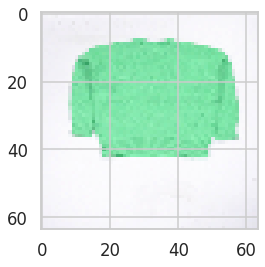

In [229]:
# Image Sample
plt.imshow(img_set[200])

<Figure size 432x288 with 0 Axes>

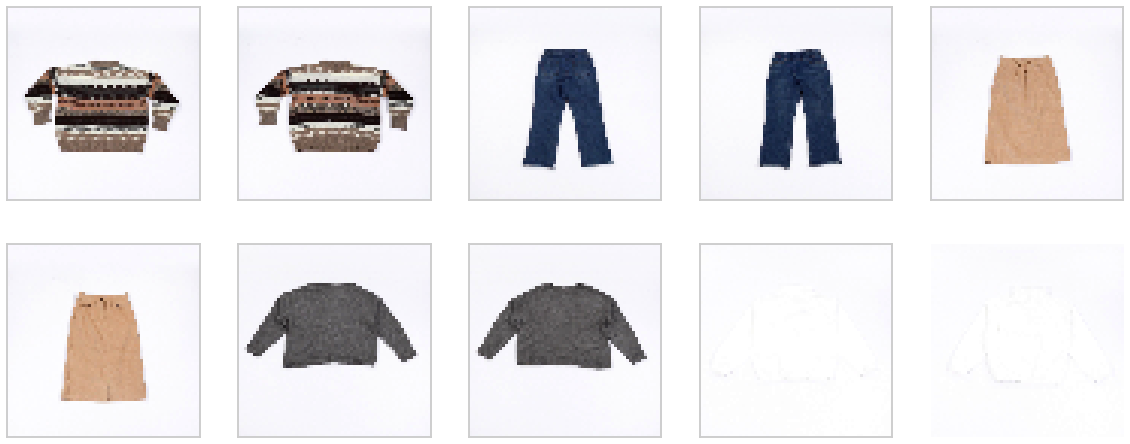

In [230]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [231]:
# Data Normalization
img_scaled = img_set/255
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (246, 64, 64, 3) 216.80223484607893
Scaled Image Format : (246, 64, 64, 3) 0.850204842533643


In [234]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(196, 64, 64, 3) 196
(50, 64, 64, 3) 50


## 3. Convolutional Autoencoder Modeling

### Encoder

In [90]:
# Encoder Part Modeling
tf.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

L1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)
L3 = Conv2D(16, (3, 3), activation='relu', padding='same')(L2)
L4 = MaxPooling2D((2, 2))(L3)
L5 = Conv2D(8, (3, 3), activation='relu', padding='same')(L4)
L6 = MaxPooling2D((2, 2))(L5)
L7 = Conv2D(8, (3, 3), activation='relu', padding='same')(L6)
L8 = MaxPooling2D((2, 2))(L7)

encoder_output = L8

In [91]:
# Encoder Summary()
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160  

In [ ]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0810.png', show_shapes=True)

### Decoder

In [92]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

L9 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L10 = UpSampling2D((2, 2))(L9)
L11 = Conv2D(8, (3, 3), activation='relu', padding='same')(L10)
L12 = UpSampling2D((2, 2))(L11)
L13 = Conv2D(16, (3, 3), activation='relu', padding='same')(L12)
L14 = UpSampling2D((2, 2))(L13)
L15 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(L14)
L16 = UpSampling2D((2, 2))(L15)
L17 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L16)

decoder_output = L17

In [93]:
# Decoder Summary()
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        1168

In [ ]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0810.png', show_shapes=True)

### AutoEncoder (Encoder + Decoder)

In [94]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = keras.Model(init_input, connect_output)

In [95]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [96]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 8)           7264      
                                                                 
 model_1 (Functional)        (None, 64, 64, 3)         7843      
                                                                 
Total params: 15,107
Trainable params: 15,107
Non-trainable params: 0
_________________________________________________________________


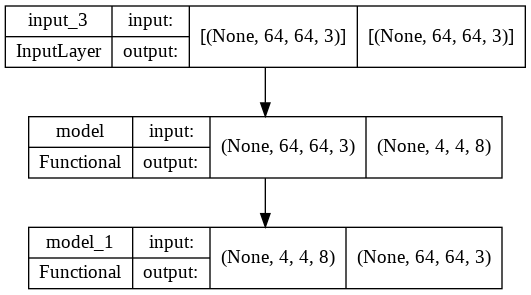

In [97]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0810.png', show_shapes=True)

In [98]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [99]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 10

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/19           ETA: ?s - 

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.4785
Epoch 1: val_loss improved from inf to 0.44272, saving model to Training-checkpoint/cp-0001-0.44.ckpt
19/19 [==============================] - 1s 23ms/step - loss: 0.4785 - val_loss: 0.4427
Epoch 2/100


0/19           ETA: ?s - 

Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.4217
Epoch 2: val_loss improved from 0.44272 to 0.41743, saving model to Training-checkpoint/cp-0002-0.42.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.4227 - val_loss: 0.4174
Epoch 3/100


0/19           ETA: ?s - 

Epoch 3/100
15/19 [======================>.......] - ETA: 0s - loss: 0.3691
Epoch 3: val_loss improved from 0.41743 to 0.34997, saving model to Training-checkpoint/cp-0003-0.35.ckpt
19/19 [==============================] - 0s 12ms/step - loss: 0.3648 - val_loss: 0.3500
Epoch 4/100


0/19           ETA: ?s - 

Epoch 4/100
14/19 [=====================>........] - ETA: 0s - loss: 0.3454
Epoch 4: val_loss improved from 0.34997 to 0.33989, saving model to Training-checkpoint/cp-0004-0.34.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.3390 - val_loss: 0.3399
Epoch 5/100


0/19           ETA: ?s - 

Epoch 5/100
14/19 [=====================>........] - ETA: 0s - loss: 0.3223
Epoch 5: val_loss improved from 0.33989 to 0.33169, saving model to Training-checkpoint/cp-0005-0.33.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.3297 - val_loss: 0.3317
Epoch 6/100


0/19           ETA: ?s - 

Epoch 6/100
19/19 [==============================] - ETA: 0s - loss: 0.3103
Epoch 6: val_loss improved from 0.33169 to 0.30117, saving model to Training-checkpoint/cp-0006-0.30.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.3103 - val_loss: 0.3012
Epoch 7/100


0/19           ETA: ?s - 

Epoch 7/100
19/19 [==============================] - ETA: 0s - loss: 0.2900
Epoch 7: val_loss improved from 0.30117 to 0.29734, saving model to Training-checkpoint/cp-0007-0.30.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2900 - val_loss: 0.2973
Epoch 8/100


0/19           ETA: ?s - 

Epoch 8/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2829
Epoch 8: val_loss improved from 0.29734 to 0.28032, saving model to Training-checkpoint/cp-0008-0.28.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2808 - val_loss: 0.2803
Epoch 9/100


0/19           ETA: ?s - 

Epoch 9/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2735
Epoch 9: val_loss improved from 0.28032 to 0.27765, saving model to Training-checkpoint/cp-0009-0.28.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2727 - val_loss: 0.2776
Epoch 10/100


0/19           ETA: ?s - 

Epoch 10/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2657
Epoch 10: val_loss improved from 0.27765 to 0.27158, saving model to Training-checkpoint/cp-0010-0.27.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2708 - val_loss: 0.2716
Epoch 11/100


0/19           ETA: ?s - 

Epoch 11/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2661
Epoch 11: val_loss improved from 0.27158 to 0.26975, saving model to Training-checkpoint/cp-0011-0.27.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2679 - val_loss: 0.2698
Epoch 12/100


0/19           ETA: ?s - 

Epoch 12/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2692
Epoch 12: val_loss improved from 0.26975 to 0.26494, saving model to Training-checkpoint/cp-0012-0.26.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2660 - val_loss: 0.2649
Epoch 13/100


0/19           ETA: ?s - 

Epoch 13/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2630
Epoch 13: val_loss improved from 0.26494 to 0.26240, saving model to Training-checkpoint/cp-0013-0.26.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2624 - val_loss: 0.2624
Epoch 14/100


0/19           ETA: ?s - 

Epoch 14/100
19/19 [==============================] - ETA: 0s - loss: 0.2591
Epoch 14: val_loss improved from 0.26240 to 0.26129, saving model to Training-checkpoint/cp-0014-0.26.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2591 - val_loss: 0.2613
Epoch 15/100


0/19           ETA: ?s - 

Epoch 15/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2597
Epoch 15: val_loss improved from 0.26129 to 0.25837, saving model to Training-checkpoint/cp-0015-0.26.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2575 - val_loss: 0.2584
Epoch 16/100


0/19           ETA: ?s - 

Epoch 16/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2551
Epoch 16: val_loss improved from 0.25837 to 0.25678, saving model to Training-checkpoint/cp-0016-0.26.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2563 - val_loss: 0.2568
Epoch 17/100


0/19           ETA: ?s - 

Epoch 17/100
19/19 [==============================] - ETA: 0s - loss: 0.2546
Epoch 17: val_loss improved from 0.25678 to 0.25576, saving model to Training-checkpoint/cp-0017-0.26.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2546 - val_loss: 0.2558
Epoch 18/100


0/19           ETA: ?s - 

Epoch 18/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2537
Epoch 18: val_loss did not improve from 0.25576
19/19 [==============================] - 0s 10ms/step - loss: 0.2538 - val_loss: 0.2568
Epoch 19/100


0/19           ETA: ?s - 

Epoch 19/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2520
Epoch 19: val_loss improved from 0.25576 to 0.25474, saving model to Training-checkpoint/cp-0019-0.25.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2546 - val_loss: 0.2547
Epoch 20/100


0/19           ETA: ?s - 

Epoch 20/100
15/19 [======================>.......] - ETA: 0s - loss: 0.2537
Epoch 20: val_loss improved from 0.25474 to 0.25346, saving model to Training-checkpoint/cp-0020-0.25.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2524 - val_loss: 0.2535
Epoch 21/100


0/19           ETA: ?s - 

Epoch 21/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2548
Epoch 21: val_loss improved from 0.25346 to 0.25309, saving model to Training-checkpoint/cp-0021-0.25.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2521 - val_loss: 0.2531
Epoch 22/100


0/19           ETA: ?s - 

Epoch 22/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2494
Epoch 22: val_loss improved from 0.25309 to 0.25129, saving model to Training-checkpoint/cp-0022-0.25.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2503 - val_loss: 0.2513
Epoch 23/100


0/19           ETA: ?s - 

Epoch 23/100
12/19 [=================>............] - ETA: 0s - loss: 0.2470
Epoch 23: val_loss did not improve from 0.25129
19/19 [==============================] - 0s 11ms/step - loss: 0.2494 - val_loss: 0.2513
Epoch 24/100


0/19           ETA: ?s - 

Epoch 24/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2522
Epoch 24: val_loss did not improve from 0.25129
19/19 [==============================] - 0s 11ms/step - loss: 0.2489 - val_loss: 0.2515
Epoch 25/100


0/19           ETA: ?s - 

Epoch 25/100
15/19 [======================>.......] - ETA: 0s - loss: 0.2456
Epoch 25: val_loss improved from 0.25129 to 0.24936, saving model to Training-checkpoint/cp-0025-0.25.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2481 - val_loss: 0.2494
Epoch 26/100


0/19           ETA: ?s - 

Epoch 26/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2476
Epoch 26: val_loss improved from 0.24936 to 0.24896, saving model to Training-checkpoint/cp-0026-0.25.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2475 - val_loss: 0.2490
Epoch 27/100


0/19           ETA: ?s - 

Epoch 27/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2466
Epoch 27: val_loss did not improve from 0.24896
19/19 [==============================] - 0s 9ms/step - loss: 0.2472 - val_loss: 0.2527
Epoch 28/100


0/19           ETA: ?s - 

Epoch 28/100
15/19 [======================>.......] - ETA: 0s - loss: 0.2441
Epoch 28: val_loss improved from 0.24896 to 0.24873, saving model to Training-checkpoint/cp-0028-0.25.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2476 - val_loss: 0.2487
Epoch 29/100


0/19           ETA: ?s - 

Epoch 29/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2473
Epoch 29: val_loss did not improve from 0.24873
19/19 [==============================] - 0s 20ms/step - loss: 0.2465 - val_loss: 0.2487
Epoch 30/100


0/19           ETA: ?s - 

Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 0.2448
Epoch 30: val_loss improved from 0.24873 to 0.24658, saving model to Training-checkpoint/cp-0030-0.25.ckpt
19/19 [==============================] - 0s 24ms/step - loss: 0.2448 - val_loss: 0.2466
Epoch 31/100


0/19           ETA: ?s - 

Epoch 31/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2436
Epoch 31: val_loss did not improve from 0.24658
19/19 [==============================] - 0s 10ms/step - loss: 0.2460 - val_loss: 0.2471
Epoch 32/100


0/19           ETA: ?s - 

Epoch 32/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2464
Epoch 32: val_loss improved from 0.24658 to 0.24589, saving model to Training-checkpoint/cp-0032-0.25.ckpt
19/19 [==============================] - 0s 22ms/step - loss: 0.2451 - val_loss: 0.2459
Epoch 33/100


0/19           ETA: ?s - 

Epoch 33/100
19/19 [==============================] - ETA: 0s - loss: 0.2454
Epoch 33: val_loss did not improve from 0.24589
19/19 [==============================] - 0s 18ms/step - loss: 0.2454 - val_loss: 0.2486
Epoch 34/100


0/19           ETA: ?s - 

Epoch 34/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2416
Epoch 34: val_loss improved from 0.24589 to 0.24538, saving model to Training-checkpoint/cp-0034-0.25.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2454 - val_loss: 0.2454
Epoch 35/100


0/19           ETA: ?s - 

Epoch 35/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2477
Epoch 35: val_loss improved from 0.24538 to 0.24521, saving model to Training-checkpoint/cp-0035-0.25.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2441 - val_loss: 0.2452
Epoch 36/100


0/19           ETA: ?s - 

Epoch 36/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2436
Epoch 36: val_loss did not improve from 0.24521
19/19 [==============================] - 0s 12ms/step - loss: 0.2434 - val_loss: 0.2501
Epoch 37/100


0/19           ETA: ?s - 

Epoch 37/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2452
Epoch 37: val_loss did not improve from 0.24521
19/19 [==============================] - 0s 10ms/step - loss: 0.2435 - val_loss: 0.2476
Epoch 38/100


0/19           ETA: ?s - 

Epoch 38/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2457
Epoch 38: val_loss did not improve from 0.24521
19/19 [==============================] - 0s 10ms/step - loss: 0.2425 - val_loss: 0.2497
Epoch 39/100


0/19           ETA: ?s - 

Epoch 39/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2412
Epoch 39: val_loss did not improve from 0.24521
19/19 [==============================] - 0s 10ms/step - loss: 0.2420 - val_loss: 0.2454
Epoch 40/100


0/19           ETA: ?s - 

Epoch 40/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2420
Epoch 40: val_loss improved from 0.24521 to 0.24404, saving model to Training-checkpoint/cp-0040-0.24.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2412 - val_loss: 0.2440
Epoch 41/100


0/19           ETA: ?s - 

Epoch 41/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2404
Epoch 41: val_loss improved from 0.24404 to 0.24374, saving model to Training-checkpoint/cp-0041-0.24.ckpt
19/19 [==============================] - 0s 16ms/step - loss: 0.2411 - val_loss: 0.2437
Epoch 42/100


0/19           ETA: ?s - 

Epoch 42/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2445
Epoch 42: val_loss did not improve from 0.24374
19/19 [==============================] - 0s 10ms/step - loss: 0.2409 - val_loss: 0.2453
Epoch 43/100


0/19           ETA: ?s - 

Epoch 43/100
15/19 [======================>.......] - ETA: 0s - loss: 0.2423
Epoch 43: val_loss improved from 0.24374 to 0.24293, saving model to Training-checkpoint/cp-0043-0.24.ckpt
19/19 [==============================] - 0s 13ms/step - loss: 0.2411 - val_loss: 0.2429
Epoch 44/100


0/19           ETA: ?s - 

Epoch 44/100
19/19 [==============================] - ETA: 0s - loss: 0.2403
Epoch 44: val_loss improved from 0.24293 to 0.24260, saving model to Training-checkpoint/cp-0044-0.24.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2403 - val_loss: 0.2426
Epoch 45/100


0/19           ETA: ?s - 

Epoch 45/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2455
Epoch 45: val_loss improved from 0.24260 to 0.24254, saving model to Training-checkpoint/cp-0045-0.24.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2407 - val_loss: 0.2425
Epoch 46/100


0/19           ETA: ?s - 

Epoch 46/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2395
Epoch 46: val_loss did not improve from 0.24254
19/19 [==============================] - 0s 11ms/step - loss: 0.2398 - val_loss: 0.2436
Epoch 47/100


0/19           ETA: ?s - 

Epoch 47/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2398
Epoch 47: val_loss did not improve from 0.24254
19/19 [==============================] - 0s 10ms/step - loss: 0.2404 - val_loss: 0.2430
Epoch 48/100


0/19           ETA: ?s - 

Epoch 48/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2391
Epoch 48: val_loss did not improve from 0.24254
19/19 [==============================] - 0s 10ms/step - loss: 0.2397 - val_loss: 0.2428
Epoch 49/100


0/19           ETA: ?s - 

Epoch 49/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2428
Epoch 49: val_loss improved from 0.24254 to 0.24195, saving model to Training-checkpoint/cp-0049-0.24.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2393 - val_loss: 0.2419
Epoch 50/100


0/19           ETA: ?s - 

Epoch 50/100
15/19 [======================>.......] - ETA: 0s - loss: 0.2362
Epoch 50: val_loss did not improve from 0.24195
19/19 [==============================] - 0s 9ms/step - loss: 0.2386 - val_loss: 0.2422
Epoch 51/100


0/19           ETA: ?s - 

Epoch 51/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2388
Epoch 51: val_loss improved from 0.24195 to 0.24143, saving model to Training-checkpoint/cp-0051-0.24.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2387 - val_loss: 0.2414
Epoch 52/100


0/19           ETA: ?s - 

Epoch 52/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2395
Epoch 52: val_loss did not improve from 0.24143
19/19 [==============================] - 0s 11ms/step - loss: 0.2386 - val_loss: 0.2422
Epoch 53/100


0/19           ETA: ?s - 

Epoch 53/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2381
Epoch 53: val_loss did not improve from 0.24143
19/19 [==============================] - 0s 10ms/step - loss: 0.2384 - val_loss: 0.2441
Epoch 54/100


0/19           ETA: ?s - 

Epoch 54/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2409
Epoch 54: val_loss did not improve from 0.24143
19/19 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.2425
Epoch 55/100


0/19           ETA: ?s - 

Epoch 55/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2385
Epoch 55: val_loss improved from 0.24143 to 0.24091, saving model to Training-checkpoint/cp-0055-0.24.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2381 - val_loss: 0.2409
Epoch 56/100


0/19           ETA: ?s - 

Epoch 56/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2395
Epoch 56: val_loss did not improve from 0.24091
19/19 [==============================] - 0s 10ms/step - loss: 0.2380 - val_loss: 0.2417
Epoch 57/100


0/19           ETA: ?s - 

Epoch 57/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2428
Epoch 57: val_loss did not improve from 0.24091
19/19 [==============================] - 0s 10ms/step - loss: 0.2391 - val_loss: 0.2455
Epoch 58/100


0/19           ETA: ?s - 

Epoch 58/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2405
Epoch 58: val_loss did not improve from 0.24091
19/19 [==============================] - 0s 11ms/step - loss: 0.2392 - val_loss: 0.2425
Epoch 59/100


0/19           ETA: ?s - 

Epoch 59/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2397
Epoch 59: val_loss did not improve from 0.24091
19/19 [==============================] - 0s 11ms/step - loss: 0.2386 - val_loss: 0.2422
Epoch 60/100


0/19           ETA: ?s - 

Epoch 60/100
19/19 [==============================] - ETA: 0s - loss: 0.2383
Epoch 60: val_loss did not improve from 0.24091
19/19 [==============================] - 0s 10ms/step - loss: 0.2383 - val_loss: 0.2412
Epoch 61/100


0/19           ETA: ?s - 

Epoch 61/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2369
Epoch 61: val_loss did not improve from 0.24091
19/19 [==============================] - 0s 10ms/step - loss: 0.2368 - val_loss: 0.2413
Epoch 62/100


0/19           ETA: ?s - 

Epoch 62/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2362
Epoch 62: val_loss improved from 0.24091 to 0.24053, saving model to Training-checkpoint/cp-0062-0.24.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2362 - val_loss: 0.2405
Epoch 63/100


0/19           ETA: ?s - 

Epoch 63/100
19/19 [==============================] - ETA: 0s - loss: 0.2361
Epoch 63: val_loss did not improve from 0.24053
19/19 [==============================] - 0s 10ms/step - loss: 0.2361 - val_loss: 0.2412
Epoch 64/100


0/19           ETA: ?s - 

Epoch 64/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2327
Epoch 64: val_loss improved from 0.24053 to 0.23995, saving model to Training-checkpoint/cp-0064-0.24.ckpt
19/19 [==============================] - 0s 15ms/step - loss: 0.2360 - val_loss: 0.2399
Epoch 65/100


0/19           ETA: ?s - 

Epoch 65/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2363
Epoch 65: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 12ms/step - loss: 0.2358 - val_loss: 0.2401
Epoch 66/100


0/19           ETA: ?s - 

Epoch 66/100
19/19 [==============================] - ETA: 0s - loss: 0.2360
Epoch 66: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 14ms/step - loss: 0.2360 - val_loss: 0.2404
Epoch 67/100


0/19           ETA: ?s - 

Epoch 67/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2343
Epoch 67: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 21ms/step - loss: 0.2359 - val_loss: 0.2425
Epoch 68/100


0/19           ETA: ?s - 

Epoch 68/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2368
Epoch 68: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 19ms/step - loss: 0.2369 - val_loss: 0.2411
Epoch 69/100


0/19           ETA: ?s - 

Epoch 69/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2377
Epoch 69: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 17ms/step - loss: 0.2367 - val_loss: 0.2420
Epoch 70/100


0/19           ETA: ?s - 

Epoch 70/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2338
Epoch 70: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 16ms/step - loss: 0.2352 - val_loss: 0.2400
Epoch 71/100


0/19           ETA: ?s - 

Epoch 71/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2361
Epoch 71: val_loss did not improve from 0.23995
19/19 [==============================] - 0s 16ms/step - loss: 0.2355 - val_loss: 0.2410
Epoch 72/100


0/19           ETA: ?s - 

Epoch 72/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2380
Epoch 72: val_loss improved from 0.23995 to 0.23946, saving model to Training-checkpoint/cp-0072-0.24.ckpt
19/19 [==============================] - 1s 26ms/step - loss: 0.2351 - val_loss: 0.2395
Epoch 73/100


0/19           ETA: ?s - 

Epoch 73/100
19/19 [==============================] - ETA: 0s - loss: 0.2347
Epoch 73: val_loss did not improve from 0.23946
19/19 [==============================] - 0s 22ms/step - loss: 0.2347 - val_loss: 0.2401
Epoch 74/100


0/19           ETA: ?s - 

Epoch 74/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2368
Epoch 74: val_loss did not improve from 0.23946
19/19 [==============================] - 0s 20ms/step - loss: 0.2350 - val_loss: 0.2397
Epoch 75/100


0/19           ETA: ?s - 

Epoch 75/100
19/19 [==============================] - ETA: 0s - loss: 0.2345
Epoch 75: val_loss did not improve from 0.23946
19/19 [==============================] - 0s 22ms/step - loss: 0.2345 - val_loss: 0.2406
Epoch 76/100


0/19           ETA: ?s - 

Epoch 76/100
19/19 [==============================] - ETA: 0s - loss: 0.2345
Epoch 76: val_loss improved from 0.23946 to 0.23920, saving model to Training-checkpoint/cp-0076-0.24.ckpt
19/19 [==============================] - 1s 28ms/step - loss: 0.2345 - val_loss: 0.2392
Epoch 77/100


0/19           ETA: ?s - 

Epoch 77/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2380
Epoch 77: val_loss did not improve from 0.23920
19/19 [==============================] - 0s 22ms/step - loss: 0.2343 - val_loss: 0.2394
Epoch 78/100


0/19           ETA: ?s - 

Epoch 78/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2335
Epoch 78: val_loss did not improve from 0.23920
19/19 [==============================] - 0s 13ms/step - loss: 0.2339 - val_loss: 0.2401
Epoch 79/100


0/19           ETA: ?s - 

Epoch 79/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2335
Epoch 79: val_loss did not improve from 0.23920
19/19 [==============================] - 0s 18ms/step - loss: 0.2339 - val_loss: 0.2400
Epoch 80/100


0/19           ETA: ?s - 

Epoch 80/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2340
Epoch 80: val_loss improved from 0.23920 to 0.23865, saving model to Training-checkpoint/cp-0080-0.24.ckpt
19/19 [==============================] - 0s 22ms/step - loss: 0.2337 - val_loss: 0.2387
Epoch 81/100


0/19           ETA: ?s - 

Epoch 81/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2342
Epoch 81: val_loss improved from 0.23865 to 0.23844, saving model to Training-checkpoint/cp-0081-0.24.ckpt
19/19 [==============================] - 0s 26ms/step - loss: 0.2334 - val_loss: 0.2384
Epoch 82/100


0/19           ETA: ?s - 

Epoch 82/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2327
Epoch 82: val_loss did not improve from 0.23844
19/19 [==============================] - 0s 18ms/step - loss: 0.2336 - val_loss: 0.2386
Epoch 83/100


0/19           ETA: ?s - 

Epoch 83/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2329
Epoch 83: val_loss did not improve from 0.23844
19/19 [==============================] - 0s 14ms/step - loss: 0.2339 - val_loss: 0.2385
Epoch 84/100


0/19           ETA: ?s - 

Epoch 84/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2323
Epoch 84: val_loss did not improve from 0.23844
19/19 [==============================] - 0s 16ms/step - loss: 0.2337 - val_loss: 0.2398
Epoch 85/100


0/19           ETA: ?s - 

Epoch 85/100
19/19 [==============================] - ETA: 0s - loss: 0.2331
Epoch 85: val_loss improved from 0.23844 to 0.23789, saving model to Training-checkpoint/cp-0085-0.24.ckpt
19/19 [==============================] - 1s 27ms/step - loss: 0.2331 - val_loss: 0.2379
Epoch 86/100


0/19           ETA: ?s - 

Epoch 86/100
17/19 [=========================>....] - ETA: 0s - loss: 0.2365
Epoch 86: val_loss improved from 0.23789 to 0.23741, saving model to Training-checkpoint/cp-0086-0.24.ckpt
19/19 [==============================] - 0s 22ms/step - loss: 0.2338 - val_loss: 0.2374
Epoch 87/100


0/19           ETA: ?s - 

Epoch 87/100
16/19 [========================>.....] - ETA: 0s - loss: 0.2324
Epoch 87: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 18ms/step - loss: 0.2335 - val_loss: 0.2378
Epoch 88/100


0/19           ETA: ?s - 

Epoch 88/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2331
Epoch 88: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 10ms/step - loss: 0.2329 - val_loss: 0.2387
Epoch 89/100


0/19           ETA: ?s - 

Epoch 89/100
19/19 [==============================] - ETA: 0s - loss: 0.2328
Epoch 89: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 10ms/step - loss: 0.2328 - val_loss: 0.2397
Epoch 90/100


0/19           ETA: ?s - 

Epoch 90/100
19/19 [==============================] - ETA: 0s - loss: 0.2329
Epoch 90: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 11ms/step - loss: 0.2329 - val_loss: 0.2395
Epoch 91/100


0/19           ETA: ?s - 

Epoch 91/100
19/19 [==============================] - ETA: 0s - loss: 0.2326
Epoch 91: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 11ms/step - loss: 0.2326 - val_loss: 0.2381
Epoch 92/100


0/19           ETA: ?s - 

Epoch 92/100
19/19 [==============================] - ETA: 0s - loss: 0.2329
Epoch 92: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 10ms/step - loss: 0.2329 - val_loss: 0.2384
Epoch 93/100


0/19           ETA: ?s - 

Epoch 93/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2321
Epoch 93: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 10ms/step - loss: 0.2330 - val_loss: 0.2384
Epoch 94/100


0/19           ETA: ?s - 

Epoch 94/100
19/19 [==============================] - ETA: 0s - loss: 0.2333
Epoch 94: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 10ms/step - loss: 0.2333 - val_loss: 0.2399
Epoch 95/100


0/19           ETA: ?s - 

Epoch 95/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2341
Epoch 95: val_loss did not improve from 0.23741
19/19 [==============================] - 0s 10ms/step - loss: 0.2339 - val_loss: 0.2375
Epoch 96/100


0/19           ETA: ?s - 

Epoch 96/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2318
Epoch 96: val_loss improved from 0.23741 to 0.23721, saving model to Training-checkpoint/cp-0096-0.24.ckpt
19/19 [==============================] - 0s 14ms/step - loss: 0.2327 - val_loss: 0.2372
Epoch 97/100


0/19           ETA: ?s - 

Epoch 97/100
13/19 [===================>..........] - ETA: 0s - loss: 0.2358
Epoch 97: val_loss did not improve from 0.23721
19/19 [==============================] - 0s 11ms/step - loss: 0.2320 - val_loss: 0.2381
Epoch 98/100


0/19           ETA: ?s - 

Epoch 98/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2311
Epoch 98: val_loss did not improve from 0.23721
19/19 [==============================] - 0s 11ms/step - loss: 0.2321 - val_loss: 0.2381
Epoch 99/100


0/19           ETA: ?s - 

Epoch 99/100
19/19 [==============================] - ETA: 0s - loss: 0.2317
Epoch 99: val_loss did not improve from 0.23721
19/19 [==============================] - 0s 10ms/step - loss: 0.2317 - val_loss: 0.2380
Epoch 100/100


0/19           ETA: ?s - 

Epoch 100/100
14/19 [=====================>........] - ETA: 0s - loss: 0.2320
Epoch 100: val_loss did not improve from 0.23721
19/19 [==============================] - 0s 10ms/step - loss: 0.2317 - val_loss: 0.2377


In [100]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:41


In [101]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.head()

,loss,val_loss
0,0.478503,0.442722
1,0.422667,0.417427
2,0.364776,0.349969
3,0.339023,0.339886
4,0.329687,0.331695


In [102]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
95,0.232698,0.237211


In [ ]:
# Save Model
# Encoder Part Save
encoder.save('model_save/Encoder_0810/')

# Decoder Part Save
decoder.save('model_save/Decoder_0810/')

# Convolutional Autoencoder Model Save
model.save('model_save/ConvAE_0810/')

In [ ]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0810/')
decoder = keras.models.load_model('model_save/Decoder_0810/')
model = keras.models.load_model('model_save/ConvAE_0810/')

## 4. Performance Evaluation

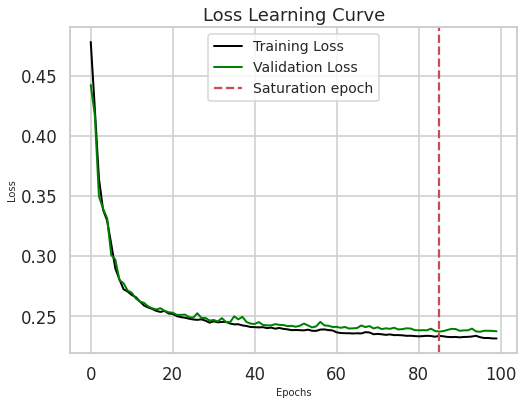

In [255]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.savefig('figure/learning_curve_0810')
plt.show()

In [122]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

2/2 [==============================] - 1s 19ms/step - loss: 0.2196
test loss : 0.2196


In [107]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

((50, 64, 64, 3), 0.8423)

<Figure size 432x288 with 0 Axes>

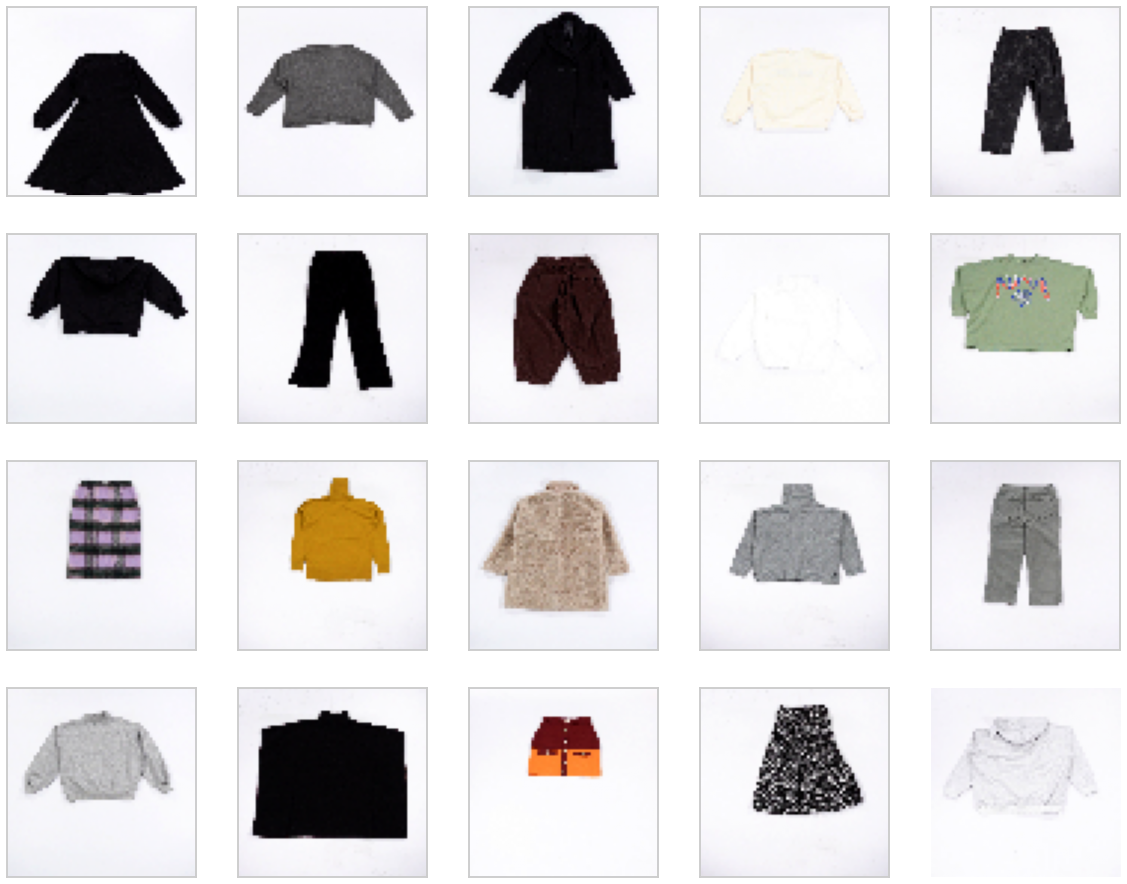

In [256]:
# Test Image Samples
_ = plot_images(4,5,X_test)

<Figure size 432x288 with 0 Axes>

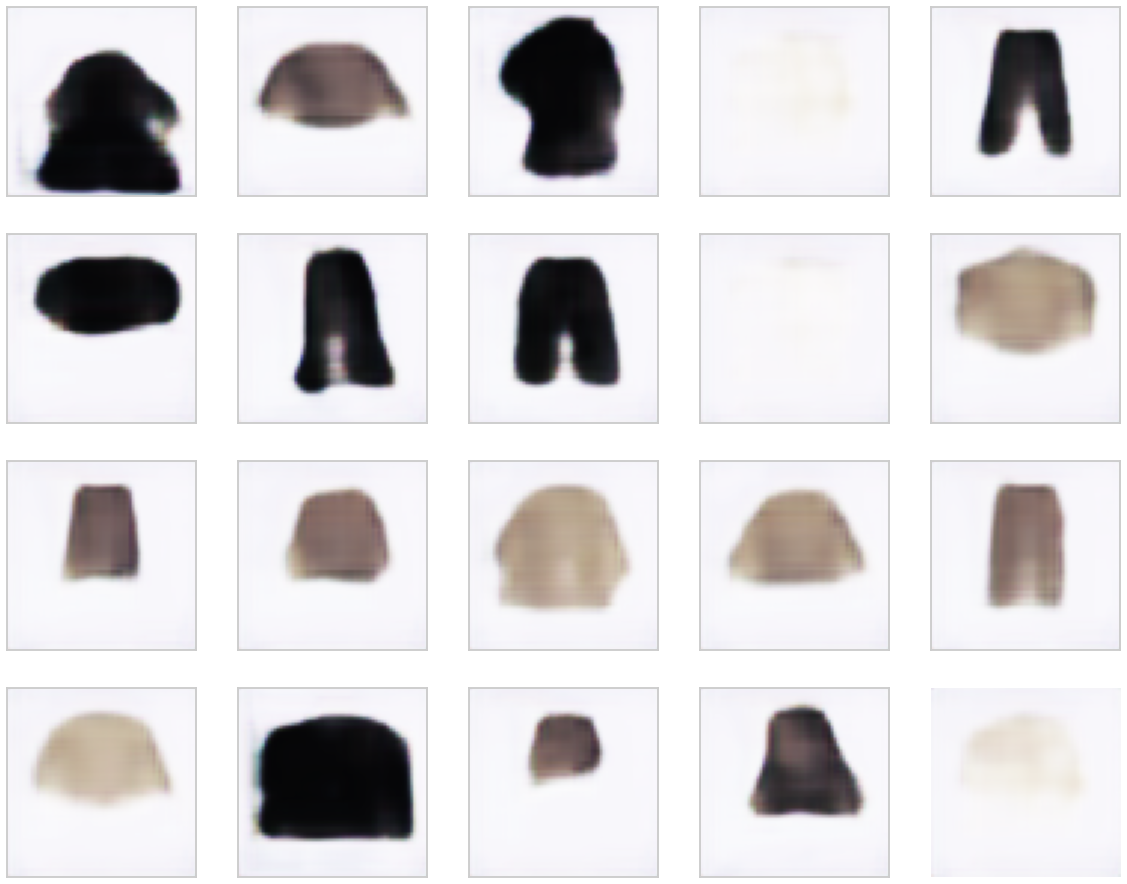

In [257]:
# Prediction Image Samples
_ = plot_images(4,5,X_pred)

In [148]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(50, list)

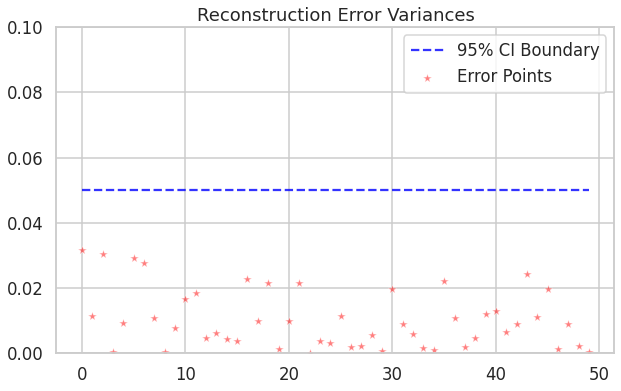

In [156]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [240]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

((246, 4, 4, 8), numpy.ndarray)

In [241]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((246, 8), numpy.ndarray)

In [242]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (246, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,0.702277,7.629118,7.222691,2.811400,5.899369,0.0,7.979069,4.713125,1008002_B.jpg
1,0.678160,7.784126,7.494220,2.745415,5.844021,0.0,7.714909,4.725790,1008002_F.jpg
2,0.739823,7.825010,5.616591,4.474674,6.424698,0.0,7.519754,4.482010,1008003_B.jpg
3,0.733444,7.889739,5.697682,4.473097,6.620075,0.0,7.456568,4.489943,1008003_F.jpg
4,0.533819,5.581106,4.357337,3.552518,5.570248,0.0,9.185352,4.315649,1012144_B.jpg


In [252]:
# Latent Feature DataFrame export to csv
df.to_csv('latent feature/latent_feature_0810.csv',index=False)

## 6. Recommendation System

In [258]:
# Latent Feature DataFrame load
df = pd.read_csv('latent feature/latent_feature_0810.csv')
print(df.shape)
df.head()

(246, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,0.702277,7.629118,7.222691,2.811400,5.899369,0.0,7.979069,4.713125,1008002_B.jpg
1,0.678160,7.784126,7.494220,2.745415,5.844021,0.0,7.714909,4.725790,1008002_F.jpg
2,0.739823,7.825010,5.616591,4.474674,6.424698,0.0,7.519754,4.482010,1008003_B.jpg
3,0.733444,7.889739,5.697682,4.473097,6.620075,0.0,7.456568,4.489943,1008003_F.jpg
4,0.533819,5.581106,4.357337,3.552518,5.570248,0.0,9.185352,4.315649,1012144_B.jpg
